In [35]:
import pandas as pd
import numpy as np
from math import *

def generar_puntos(centro, mat_cov, size):
  rng = np.random.default_rng()
  return rng.multivariate_normal(centro, mat_cov, size).tolist()

def generar_centro_a(d, val):
  return np.repeat(val, d)

def generar_centro_b(d, val):
  return np.append([val], np.repeat(0, d-1))

def taggear(lista, val):
  iter_list_tag = map(lambda x: x + [val], lista)
  # Por alguna razon, se sobreescribe list en algun lado y tengo que usar el builtin por defecto.
  return __builtins__.list(iter_list_tag)

def generar_clases(std, n, centro1, centro2):
  cov = std ** 2
  mat_cov = np.diag(d * [cov])
  size = 2*n

  clase1 = generar_puntos(centro1, mat_cov, size // 2)
  clase1_contag = taggear(clase1, 0)

  clase2 = generar_puntos(centro2, mat_cov, size // 2)
  clase2_contag = taggear(clase2, 1)
  lista = clase1_contag + clase2_contag

  colNames = __builtins__.list(range(d)) + ["Clase"]

  return pd.DataFrame(lista, columns=colNames)

def generar_clase_a(C, d, n):
  centro1a = generar_centro_a(d, 1)
  centro2a = generar_centro_a(d, -1)
  # desviación estándar igual a C * SQRT(d)
  return generar_clases(C*sqrt(d), n, centro1a, centro2a)

def generar_clase_b(C, d, n):
  centro1b = generar_centro_b(d, 1)
  centro2b = generar_centro_b(d, -1)
  # desviación estandar es igual a C independientemente de d
  return generar_clases(C, n, centro1b, centro2b)  

C = 0.75
d = 2
n = 200

df_a = generar_clase_a(C, d, n)
df_b = generar_clase_b(C, d, n)



In [36]:
import matplotlib.pyplot as plt

# Fuente: https://stackoverflow.com/a/63539077
def graph_df(df):
  # Separo los puntos por clase
  x0, y0 = df[0][df.Clase == 0], df[1][df.Clase == 0]
  x1, y1 = df[0][df.Clase == 1], df[1][df.Clase == 1]

  # Calculo los máximos y mínimos para tener límites en x e y del gráfico simétricos
  xmax, xmin = max(max(x0), max(x1)), min(min(x0), min(x1))
  ymax, ymin = max(max(y0), max(y1)), min(min(y0), min(y1))

  xmax = np.ceil(max(xmax, ymax))
  ymax = xmax
  xmin, ymin = xmax * -1, ymax * -1

  # Grafico
  _, ax = plt.subplots(figsize=(10, 10))
  ax.scatter(x0, y0, c = 'blue', label = "Clase 0")
  ax.scatter(x1, y1, c = 'red', label = "Clase 1")

  ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect='equal')

  ax.spines['bottom'].set_position('zero')
  ax.spines['left'].set_position('zero')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  
  ax.set_xlabel('x', size=14, labelpad=-24, x=1.03)
  ax.set_ylabel('y', size=14, labelpad=-21, y=1.02, rotation=0)

  x_ticks = np.arange(xmin, xmax+1, 1)
  y_ticks = np.arange(ymin, ymax+1, 1)
  ax.set_xticks(x_ticks[x_ticks != 0])
  ax.set_yticks(y_ticks[y_ticks != 0])
 
  ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)
  ax.legend()

  plt.show()


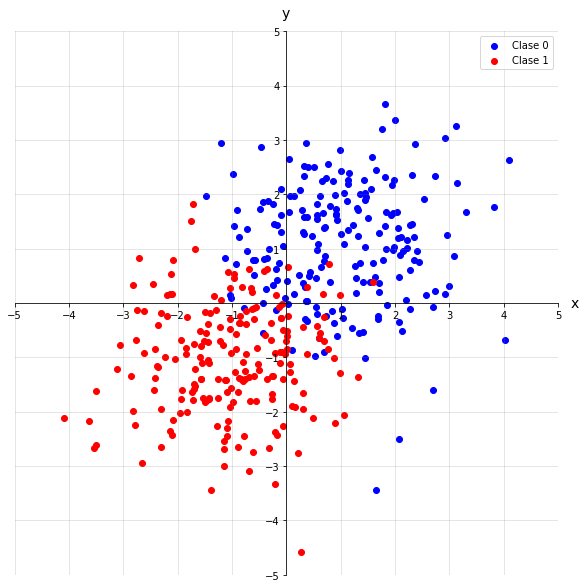

In [37]:
# Gráfico del punto a
graph_df(df_a)

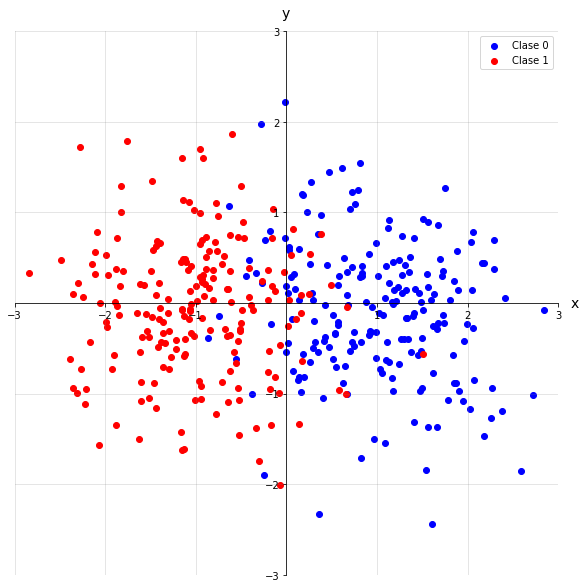

In [38]:
# Gráfico del punto b
graph_df(df_b)

In [39]:
# Para verificar los problemas a) y b), genere conjuntos con d=2, n=200 y C=0.75, y grafíquelos. 
# También genere conjuntos con d=4, n=2000 y C=2.00, 
# y verifique en el código que las medias y desviaciones estándar sean correctas.

C = 2.00
d = 4
n = 2000

df_a2 = generar_clase_a(C, d, n)
df_b2 = generar_clase_b(C, d, n)

for df in [df_a2, df_b2]:
  print("Media")
  print(df.groupby('Clase').mean())   # df_a:((-1, -1, -1, -1) y (1, 1, 1, 1)); df_b: (-1, -0, 0, 0, 0) y (1, -0, 0, 0, 0)
  print("Desviación estándar")
  print(df.groupby('Clase').std())    # df_a: 4; df_b: 2

Media
              0         1         2         3
Clase                                        
0      1.087895  0.903178  0.995565  1.047652
1     -0.914335 -0.899169 -0.890341 -0.961168
Desviación estándar
              0         1         2         3
Clase                                        
0      3.928302  4.024336  3.980435  3.958428
1      3.971694  4.139545  3.990778  4.009997
Media
              0         1         2         3
Clase                                        
0      0.980336  0.023945  0.005032  0.010026
1     -1.004314 -0.011059  0.060240  0.047142
Desviación estándar
              0         1         2         3
Clase                                        
0      2.046349  2.003073  1.949807  1.950930
1      1.992516  1.934526  2.003424  1.944274


In [40]:
# c) Espirales anidadas: Los datos tienen 2 inputs, x e y, que corresponden a puntos generados al azar con una distribución 
# # UNIFORME (en dicho sistema de referencia x-y) dentro de un circulo de radio 1. El output es binario, correspondiendo la clase 0 
# # a los puntos que se encuentran entre las curvas ro = theta/4pi y ro = (theta + pi)/4pi (en polares) y la clase 1 al resto. 
# # De los n puntos generados, n/2 deben pertenecer a cada clase.
from random import uniform
from math import dist
from cmath import polar

def curva_uno(theta):
  return theta/(4*np.pi)

def curva_dos(theta):
  return (theta + np.pi)/(4*np.pi)

def punto_uniforme(radio):    
    x, y = uniform(-radio, radio), uniform(-radio, radio)

    if dist([0, 0], [x, y]) <= radio:
      return [x, y] 
    else: # Se regenera el punto en caso de obtener uno fuera del circulo.
      return punto_uniforme(radio) 

def generar_puntos_curva(n, radio):
  puntos = [punto_uniforme(radio) for _ in range(n)]

  for i, (x, y) in enumerate(puntos):
    r, theta = polar(complex(x, y))

    es_clase_cero = curva_uno(theta) < r < curva_dos(theta) \
      or curva_uno(theta) + 0.5 < r < curva_dos(theta) + 0.5 \
      or curva_uno(theta) + 1 < r < curva_dos(theta) + 1
    
    if es_clase_cero: 
      puntos[i].append(0) 
    else: 
      puntos[i].append(1)
  return puntos

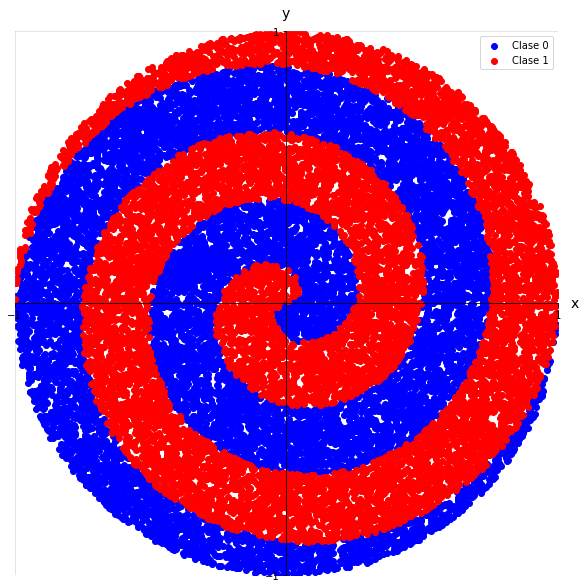

In [41]:
# Genero los puntos y grafico el espiral.
def graph_espiral(n, radio):
  puntos = generar_puntos_curva(n, radio)
  colNames = [0, 1, "Clase"] 

  df_espiral = pd.DataFrame(puntos, columns=colNames)
  graph_df(df_espiral)

n = 20000
radio = 1
graph_espiral(n, radio)